# Demo: Linear hard-margin SVM

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
from cvxopt import matrix 
from cvxopt import solvers as cvx_solver
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Generating test data

In [281]:
nsamples = 200
salmon = np.random.multivariate_normal([3,18],0.2*np.array([[3.25,-2.25],[-2.25,9.25]]),nsamples)
seabass = np.random.multivariate_normal([14.5,19], 0.1*np.array([[9.5625,1.3125],[1.3125,6.0625]]),nsamples)
X = np.concatenate((salmon,seabass))
y = [1]*nsamples + [-1]*nsamples

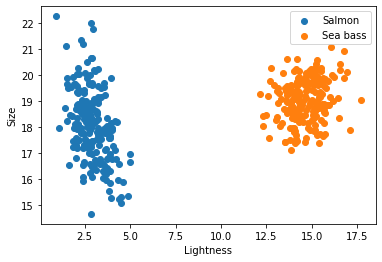

In [282]:
plt.scatter(salmon[:,0],salmon[:,1])
plt.scatter(seabass[:,0],seabass[:,1])
plt.legend(["Salmon","Sea bass"])
plt.xlabel("Lightness")
plt.ylabel("Size")
plt.show()

In [283]:
print("Size of training data points: ", np.shape(X))
print("Size of training data labels: ", np.shape(y))


Size of training data points:  (400, 2)
Size of training data labels:  (400,)


## Building our own classifier

In [284]:
import qpsolvers
import numpy.matlib

In [285]:
def train(X,y):
    # dimensions of the training data
    nsamples = np.shape(X)[0]
    ndims = np.shape(X)[1]
    
    # constructing the quadratic cost matrix
    P = np.zeros((ndims+1,ndims+1))
    P[0:ndims,0:ndims] = np.eye(ndims)
    P = P + np.eye(ndims+1)*1e-3
    print(P)
    # constructing the quadratic cost vector
    q = np.zeros(ndims+1)
    
    # constructing the linear inequality matrix
    G = np.zeros((nsamples,ndims+1))
    G[:,0:ndims] = np.multiply(np.array(np.matlib.repmat(y,ndims,1)).T,X)
    G[:,ndims] = y 
    G = -G
    print(G)
    
    # constructing the linear inequality vector
    h = -np.ones((nsamples,1))[:,0]
    
    # solving the quadratic optimization problem
    z = qpsolvers.solve_qp(P, q, G, h)
    
    w = z[0:ndims]
    b = z[ndims]
    
    return w, b

def classify(w,b,X):
    nsamples = np.shape(X)[0]
    ndims = np.shape(X)[1]
    print(w)
    # signed distance
    r = np.matmul(w,X.T) + b
    
    return r/abs(r)

### Training the classifier

In [286]:
w,b = train(X,y)

[[1.001e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.001e+00 0.000e+00]
 [0.000e+00 0.000e+00 1.000e-03]]
[[ -4.072352   -17.28075349  -1.        ]
 [ -2.69027176 -17.39407307  -1.        ]
 [ -2.88036776 -18.92487972  -1.        ]
 ...
 [ 14.31724371  18.94818693   1.        ]
 [ 14.21610718  19.13644022   1.        ]
 [ 15.52057954  20.17687154   1.        ]]


In [287]:
print("Classification hyperplane defined by")
print("w: ", w)
print("b: ", b)

Classification hyperplane defined by
w:  [-0.26838952 -0.03937911]
b:  3.014885252233555


In [288]:
    nsamples = np.shape(X)[0]
    ndims = np.shape(X)[1]
    G = np.zeros((nsamples,ndims+1))
    print(G.shape)
    G[:,0:ndims] = np.multiply(np.array(np.matlib.repmat(y,ndims,1)).T,X)
    print(G)
    G[:,ndims] = y 
    G = -G
    print(G)

(400, 3)
[[  4.072352    17.28075349   0.        ]
 [  2.69027176  17.39407307   0.        ]
 [  2.88036776  18.92487972   0.        ]
 ...
 [-14.31724371 -18.94818693   0.        ]
 [-14.21610718 -19.13644022   0.        ]
 [-15.52057954 -20.17687154   0.        ]]
[[ -4.072352   -17.28075349  -1.        ]
 [ -2.69027176 -17.39407307  -1.        ]
 [ -2.88036776 -18.92487972  -1.        ]
 ...
 [ 14.31724371  18.94818693   1.        ]
 [ 14.21610718  19.13644022   1.        ]
 [ 15.52057954  20.17687154   1.        ]]


### Classification result

[-0.26838952 -0.03937911]


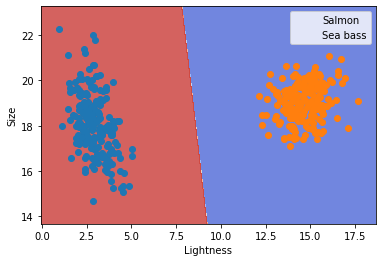

In [289]:
# construct a grid
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# classify grid points
Z = classify(w, b, np.c_[xx.ravel(), yy.ravel()])


# put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(salmon[:,0],salmon[:,1])
plt.scatter(seabass[:,0],seabass[:,1])
plt.legend(["Salmon","Sea bass"])
plt.xlabel("Lightness")
plt.ylabel("Size")
plt.show()

## But what about non-linearly-separable data?

In [290]:
nsamples = 200
salmon = np.random.multivariate_normal([3,18],0.2*np.array([[3.25,-2.25],[-2.25,9.25]]),nsamples)
seabass = np.random.multivariate_normal([5.5,19], 0.1*np.array([[9.5625,1.3125],[1.3125,6.0625]]),nsamples)
X = np.concatenate((salmon,seabass))
y = [1]*nsamples + [-1]*nsamples

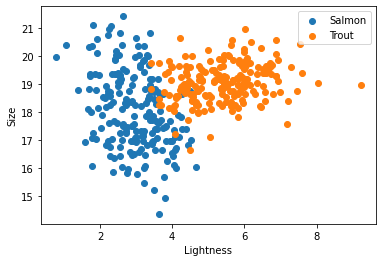

In [291]:
plt.scatter(salmon[:,0],salmon[:,1])
plt.scatter(seabass[:,0],seabass[:,1])
plt.legend(["Salmon","Trout"])
plt.xlabel("Lightness")
plt.ylabel("Size")
plt.show()

### Can the hard-margin classifier handle this case?
No, Hard Margin classifier cann't handle this case

In [292]:
len(y)

400

### Soft Margin SVM classifier

In [294]:
def train_soft(X,y,C):
    #Initializing values and computing H. Note the 1. to force to float type
    m,n = X.shape
    y = y.reshape(-1,1) * 1.
    #print(y)
    X_dash = y * X
    #print(X_dash)
    H = np.dot(X_dash , X_dash.T) * 1.

    #Converting into cvxopt format 
    P = matrix(H)
    #print(P)
    q = matrix(-np.ones((m, 1)))
    G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))

    #Run solver
    sol = cvx_solver.qp(P, q, G, h, A, b)
    # Lagrange multipliers
    a =np.array(sol['x'])

    # Support vectors have non zero lagrange multipliers
    # Weight vector
    w = ((y * a).T @ X).reshape(-1,1)
    # Intercept
    S = (a > 1e-6).flatten()
    b = y[S] - np.dot(X[S], w)

   
    return w,b.mean()
def classify(w,b,X):
    nsamples = np.shape(X)[0]
    ndims = np.shape(X)[1]
    #print(w.flatten())
    w=w.flatten()
    # signed distance
    r = np.dot(w,X.T) + b
    #print(r)
    return r/abs(r)

In [295]:

w,b = train_soft(X,np.array(y),1000.1)
y_pred = classify(np.array(w),b,X)
print("Accuracy:",accuracy_score(y,y_pred))


Accuracy: 0.9525


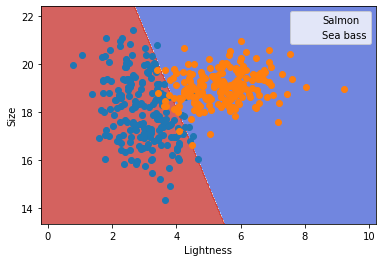

In [296]:
# construct a grid
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# classify grid points
Z = classify(w, b, np.c_[xx.ravel(), yy.ravel()])

# put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(salmon[:,0],salmon[:,1])
plt.scatter(seabass[:,0],seabass[:,1])
plt.legend(["Salmon","Sea bass"])
plt.xlabel("Lightness")
plt.ylabel("Size")
plt.show()

In [297]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

# save load_iris() sklearn dataset to iris
# if you'd like to check dataset type use: type(load_iris())
# if you'd like to view list of attributes use: dir(load_iris())
iris = load_iris()

# np.c_ is the numpy concatenate function
# which is used to concat iris['data'] and iris['target'] arrays 
# for pandas column argument: concat iris['feature_names'] list
# and string list (in this case one string); you can make this anything you'd like..  
# the original dataset would probably call this ['Species']
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])


In [298]:
#'target_names': array(['setosa', 'versicolor', 'virginica']
data1

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [299]:
#Setosa=-1 and Non Setosa=1
data2=data1.replace({'target': {2:1,0:-1}})
y=data2['target']
data3=data2.drop(['target',], axis=1)
X=np.array(data3)
y

0     -1.0
1     -1.0
2     -1.0
3     -1.0
4     -1.0
      ... 
145    1.0
146    1.0
147    1.0
148    1.0
149    1.0
Name: target, Length: 150, dtype: float64

In [300]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

C value 0.1  Accuracy: 1.0  Accuracy(F-score) 1.0
C value 0.5  Accuracy: 1.0  Accuracy(F-score) 1.0
C value 1  Accuracy: 1.0  Accuracy(F-score) 1.0
C value 5  Accuracy: 1.0  Accuracy(F-score) 1.0
C value 10  Accuracy: 1.0  Accuracy(F-score) 1.0
C value 100  Accuracy: 1.0  Accuracy(F-score) 1.0


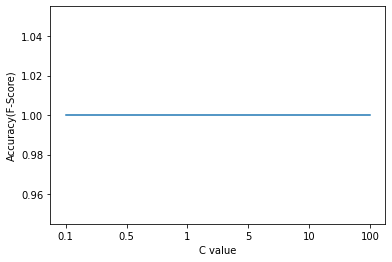

In [301]:
import math
C_list=[0.1,0.5,1,5,10,100]
F_score_list=[]
for C in C_list:
    w,b = train_soft(np.array(X_train),np.array(y_train),C)
    #print(w)
    #print(b)
    y_pred = classify(np.array(w),b,np.array(X_test))

    #print("Accuracy:",accuracy_score(y_test,y_pred))
    Accuracy_score=f1_score(y_test, y_pred)
    print('C value',C, " Accuracy:",accuracy_score(y_test,y_pred), ' Accuracy(F-score)', Accuracy_score)
    #print(Accuracy_score)
    F_score_list.append(Accuracy_score)
plt.plot([str(x) for x in C_list],F_score_list)  
plt.xlabel('C value')
plt.ylabel('Accuracy(F-Score)')
plt.show()

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  non Setosa       1.00      1.00      1.00        30

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Confusion matrix, without normalization
[[15  0]
 [ 0 30]]


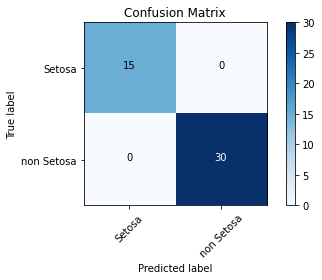

In [302]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
#best C parameter linear SVM model
w,b = train_soft(np.array(X_train),np.array(y_train),C=0.1)
y_pred = classify(np.array(w),b,np.array(X_test))
# Generate a classification report
cm_plot_labels = ['Setosa', 'non Setosa']
# For this to work we need y_pred as binary labels not as probabilities
#y_pred_binary = np.where(predictions > 0.5, 1, 0)

report = classification_report(y_test, y_pred, target_names=cm_plot_labels)

print(report)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# argmax returns the index of the max value in a row
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [304]:
#'versicolor=-1', 'non versicolor=1'
data2=data1.replace({'target': {1:-1,0:1,2:1}})
y=data2['target']
data3=data2.drop(['target',], axis=1)
X=np.array(data3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

C value 0.0001  Accuracy: 0.6666666666666666  Accuracy(F-score) 0.8
C value 0.001  Accuracy: 0.6666666666666666  Accuracy(F-score) 0.8
C value 0.01  Accuracy: 0.7333333333333333  Accuracy(F-score) 0.8285714285714285
C value 0.1  Accuracy: 0.7333333333333333  Accuracy(F-score) 0.8181818181818182
C value 0.5  Accuracy: 0.7111111111111111  Accuracy(F-score) 0.8
C value 1  Accuracy: 0.6888888888888889  Accuracy(F-score) 0.78125
C value 5  Accuracy: 0.7333333333333333  Accuracy(F-score) 0.8125
C value 10.1  Accuracy: 0.7333333333333333  Accuracy(F-score) 0.8125
C value 100.1  Accuracy: 0.7333333333333333  Accuracy(F-score) 0.8125
C value 1000.1  Accuracy: 0.7555555555555555  Accuracy(F-score) 0.819672131147541


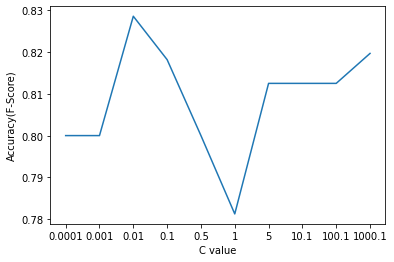

In [305]:
C_list=[0.0001,0.001,0.01,0.1,0.5,1,5,10.1,100.1,1000.1]
F_score_list=[]
for C in C_list:
    w,b = train_soft(np.array(X_train),np.array(y_train),C)
    y_pred = classify(np.array(w),b,np.array(X_test))
    Accuracy_score=f1_score(y_test, y_pred)
    print('C value',C, " Accuracy:",accuracy_score(y_test,y_pred), ' Accuracy(F-score)', Accuracy_score)
    F_score_list.append(Accuracy_score)
plt.plot([str(x) for x in C_list],F_score_list)  
plt.xlabel('C value')
plt.ylabel('Accuracy(F-Score)')
plt.show()

                precision    recall  f1-score   support

    versicolor       0.80      0.27      0.40        15
non versicolor       0.72      0.97      0.83        30

      accuracy                           0.73        45
     macro avg       0.76      0.62      0.61        45
  weighted avg       0.75      0.73      0.69        45

Confusion matrix, without normalization
[[ 4 11]
 [ 1 29]]


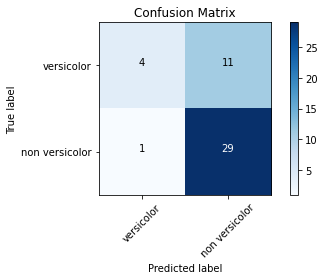

In [306]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
#best C parameter linear SVM model
w,b = train_soft(np.array(X_train),np.array(y_train),C=0.01)
y_pred = classify(np.array(w),b,np.array(X_test))
# Generate a classification report
cm_plot_labels = ['versicolor', 'non versicolor']
# For this to work we need y_pred as binary labels not as probabilities
#y_pred_binary = np.where(predictions > 0.5, 1, 0)

report = classification_report(y_test, y_pred, target_names=cm_plot_labels)

print(report)

# argmax returns the index of the max value in a row
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

#  Excercise 3: To make a multi-class classifierwe could simply make a one vs the rest classification for all the classes. E.g. for four classes: 1 vs 2-3-4, then 2 vs 1-3-4 then 3 vs 1-2-4 and finally 4 vs 1-2-3.
